# Preparación de la BBDD para poder aplicar técnicas de ML
## 1. Consideraciones iniciales

Este script permite modificar y adaptar la BBDD para poder trabajar con ella en la posterior aplicación de técnicas de ML. Para ello será necesario hacer una serie de modificaciones al estado de la misma que se irán describiendo. Además, se explica como se puede trabajar con distintas funciones del OpenSky y el tratamiento de la información para realizar un análisis previo estadístico de la muestra

In [2]:
import warnings
from traffic.data import opensky        # Cargamos opensky para poder descargar los datos
from traffic.core import Traffic        # Cargamos la función Traffic de los tipos de aeronaves
from datetime import date, timedelta    # Cargamos el fomrato de tiempo para poder trabajar con él
import pandas as pd                     # Cargamos la libreria pandas para poder trabajar con ella

warnings.filterwarnings("ignore")       # esto nos permite elimnar los avisos

C:\Users\javie\anaconda3\lib\site-packages\pkg_resources\__init__.py:1152: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
C:\Users\javie\anaconda3\lib\site-packages\ipyleaflet\leaflet.py:338: DeprecationWarning: metadata {'dtype': None} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  data = Dataset().tag(dtype=None, sync=True, to_json=ds_x_to_json)


In [3]:
# Cargamos la BBDD con la que queremos trabajar. Esta BBDD está en formato csv y debe estar en la misma carpeta que este script
# Ahora tenemos que com0probar que el csv es válido y carga los datos con la información y el dtype correspondiente
Bilbao = Traffic.from_file("Bilbao_Jan_id.csv")     #Cargamos en formato Traffic la base de datos

# Esto es algo que hay que hacer siempre al cargar un csv ya que los formatos de tiempo desaparecen
Var_time = ["hour", "last_position", "timestamp"]
Bilbao.data[Var_time] = Bilbao.data[Var_time].astype("datetime64[ns, UTC]")
Bilbao.data.info()                               #Comprobamos que se mantiene el formato y dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78036 entries, 0 to 78035
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   Unnamed: 0     78036 non-null  int64              
 1   alert          78036 non-null  bool               
 2   altitude       64846 non-null  float64            
 3   callsign       78036 non-null  object             
 4   geoaltitude    56970 non-null  float64            
 5   groundspeed    76854 non-null  float64            
 6   hour           78036 non-null  datetime64[ns, UTC]
 7   icao24         78036 non-null  object             
 8   last_position  78036 non-null  datetime64[ns, UTC]
 9   latitude       78036 non-null  float64            
 10  longitude      78036 non-null  float64            
 11  onground       78036 non-null  bool               
 12  spi            78036 non-null  bool               
 13  squawk         75930 non-null  float64        

Una vez cargado volvemos a comprobar que todos los features tienen el formato que debería tener y no todos son tipo object.

##  2.Análisis de la BBDD
Si analizamos la muestra observamos que hay 18 features (contnado el 0). Todos ellos responden a la informacion que nosotros hemos cargado. No obstante hay un problema con la columna 0 (Unnamed: 0) que habrá que quitarla porque no existe en el formato opensky para aplicar sus funciones, este feature aparece porque hemos cargado la BBDD de un csv
El nº 17 es el formato flight_id que nos va a permitir filtrar por cada uno de los vuelos con los que queremos trabajar.

Como observamos de la información que proporciona al final tenemos una BBDD que ocupa 9.2 MB, existen 3 variables que tienen un formato booleano, es decir, toman False o True, hay 8 features con formato float64 (número decimal), uno con formato int64 (número entero) y 6 con formato object (formato genérico).

El número total de muestras o filas que dispone la BBDD es de 78036 (va desde 0 hasta 78035). 

Por último podemos saber cuantas filas están rellenadas para cada una de los atributos a partir del número de filas que son Non-Nan (no están vacías). Observamos que casi todas tienen datos completos o casi completos salvo altitude (le faltan unos 12000) y geoaltitude (le faltan unos 30000). Estas celdas vacias habrá que rellenarlas o eliminar las filas dependiendo del modelo que se quiera seguir en el futuro. 

In [4]:
# Nº de vulos que existen
Bilbao

,count
flight_id,
DLH99F_091,1915
TAP1062_147,1148
IBE0448_081,1138
VLG14AT_038,1071
BAW466_119,1064
AEA7161_019,1036
VLG25BF_054,1036
IBE0440_017,1013
EZY6241_115,1011


Como observamos existen 183 identifiers en nuestra BBDD, además la informacion anterior nos informa de que aeronaves proporcionan un mayor nº de datos ADS-B en la muestra

### 2.2 Modificación de la BBDD
En primer lugar para poder trabajar con la BBDD es eliminar la columna Unnamed 0 

In [5]:
# Eliminamos de la BBDD la columna Unnamed
Bilbao = Bilbao.drop("Unnamed: 0", axis = 1)

In [6]:
# Comprobamos que la columna Unnamed ha desaparecido:
Bilbao.data.columns

Index(['alert', 'altitude', 'callsign', 'geoaltitude', 'groundspeed', 'hour',
       'icao24', 'last_position', 'latitude', 'longitude', 'onground', 'spi',
       'squawk', 'timestamp', 'track', 'vertical_rate', 'flight_id'],
      dtype='object')

In [7]:
# Aplicamos el método describe() para conocer valores estadísticos
Bilbao.data.describe()

,altitude,geoaltitude,groundspeed,latitude,longitude,squawk,track,vertical_rate
count,64846.000000,56970.000000,76854.000000,78036.000000,78036.000000,75930.000000,76854.000000,76854.000000
mean,17108.895306,15708.567667,247.791543,43.258514,-2.851877,3981.216515,216.282651,175.514092
std,15175.031538,14240.347957,129.726640,0.094147,0.164480,1926.577658,115.496175,1373.166171
min,150.000000,125.000000,59.033838,42.978836,-3.172430,52.000000,0.000000,-3840.000000
25%,4150.000000,3525.000000,134.614147,43.201309,-2.936632,2514.000000,116.365415,-768.000000
50%,9925.000000,8300.000000,190.591021,43.299259,-2.910053,4564.000000,296.175290,-64.000000
75%,34000.000000,33575.000000,381.319746,43.307739,-2.761754,5322.000000,296.787127,64.000000
max,105900.000000,90150.000000,559.708369,43.411777,-2.463045,7716.000000,359.850011,6784.000000


Como observamo tenemos las siguientes variables en float64 que permite aplicar el método describe(). Las características que podemos ver son las siguientes:
- La variable altitude tiene una media de 17108 ft y la geo altitude de 15700. Un valor mínimo de 150 ft y de 125 por lo que tenemos que eliminar todas aquellas que no operen en unas altitudes que nos interesen. 
- Del vertical_rate podemos observar que la media es de 175 ft/ min lo que quiere decir que tenemos pocas variables distintas de cero, aunque habría que analizarlo con más detalle. 

In [8]:
# Para saber cual es la columna que tienen valores nulos son los siguientes
Bilbao.data[pd.isnull(Bilbao.data['vertical_rate'])]['vertical_rate']


6538    NaN
6539    NaN
6540    NaN
6541    NaN
6542    NaN
         ..
66301   NaN
66302   NaN
66303   NaN
66304   NaN
66305   NaN
Name: vertical_rate, Length: 1182, dtype: float64

In [9]:
# Imprimimos todas las variables para saber con cuales nos quedamos
Bilbao.data.head()

,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,last_position,latitude,longitude,onground,spi,squawk,timestamp,track,vertical_rate,flight_id
0,False,34000.0,RAM802,33650.0,429.144127,2019-01-31 12:00:00+00:00,0200fb,2019-01-31 12:59:26.059000064+00:00,42.980331,-3.056292,False,False,6435.0,2019-01-31 12:59:27+00:00,15.266828,0.0,RAM802_000
1,False,34000.0,RAM802,33650.0,429.144127,2019-01-31 12:00:00+00:00,0200fb,2019-01-31 12:59:26.059000064+00:00,42.980331,-3.056292,False,False,6435.0,2019-01-31 12:59:28+00:00,15.266828,0.0,RAM802_000
2,False,34000.0,RAM802,33650.0,429.144127,2019-01-31 12:00:00+00:00,0200fb,2019-01-31 12:59:26.059000064+00:00,42.980331,-3.056292,False,False,6435.0,2019-01-31 12:59:29+00:00,15.266828,0.0,RAM802_000
3,False,34000.0,RAM802,33650.0,429.330504,2019-01-31 12:00:00+00:00,0200fb,2019-01-31 12:59:26.059000064+00:00,42.980331,-3.056292,False,False,6435.0,2019-01-31 12:59:30+00:00,14.845452,0.0,RAM802_000
4,False,34000.0,RAM802,33650.0,429.330504,2019-01-31 12:00:00+00:00,0200fb,2019-01-31 12:59:26.059000064+00:00,42.980331,-3.056292,False,False,6435.0,2019-01-31 12:59:31+00:00,14.845452,0.0,RAM802_000


Hay que quitar:
1. Eliminar todoos los vuelos que estan en ascenso y descenso. 
2. Todas las trayectorias que estén volando por debajo de 30000 ft, si no las quitamos las aeronaves por debajo de estas vuelan a velocidades más bajas que las nuestras.
3. Eliminar todos vuelos duplicados y posibles problemas al aplicar la función clean_invalid de Opensky
3. Ver las variables que tienen huecos y ver si los podemos rellenar y cual es el metodo a utilizar, si se rellenan con ceros o si se rellenan con el valor medio o se imputan como una regresion.

También hay que introducir:
1. Cual es la compañía aérea 
2. Saber como trabajar entre las distintas posiciones


In [10]:
# Nombramos las variables que queremos eliminar y las eliminamos, como podremos observar quitar las variables no afecta para poder trabajando
var_rem = ['alert', 'onground', 'spi', 'squawk']
Bilbao_red = Bilbao.drop(var_rem, axis = 1)

In [11]:
Bilbao_red.data.head()

,altitude,callsign,geoaltitude,groundspeed,hour,icao24,last_position,latitude,longitude,timestamp,track,vertical_rate,flight_id
0,34000.0,RAM802,33650.0,429.144127,2019-01-31 12:00:00+00:00,0200fb,2019-01-31 12:59:26.059000064+00:00,42.980331,-3.056292,2019-01-31 12:59:27+00:00,15.266828,0.0,RAM802_000
1,34000.0,RAM802,33650.0,429.144127,2019-01-31 12:00:00+00:00,0200fb,2019-01-31 12:59:26.059000064+00:00,42.980331,-3.056292,2019-01-31 12:59:28+00:00,15.266828,0.0,RAM802_000
2,34000.0,RAM802,33650.0,429.144127,2019-01-31 12:00:00+00:00,0200fb,2019-01-31 12:59:26.059000064+00:00,42.980331,-3.056292,2019-01-31 12:59:29+00:00,15.266828,0.0,RAM802_000
3,34000.0,RAM802,33650.0,429.330504,2019-01-31 12:00:00+00:00,0200fb,2019-01-31 12:59:26.059000064+00:00,42.980331,-3.056292,2019-01-31 12:59:30+00:00,14.845452,0.0,RAM802_000
4,34000.0,RAM802,33650.0,429.330504,2019-01-31 12:00:00+00:00,0200fb,2019-01-31 12:59:26.059000064+00:00,42.980331,-3.056292,2019-01-31 12:59:31+00:00,14.845452,0.0,RAM802_000


In [12]:
# El siguiente paso es eliminar todos los vuelos que están ascendiendo o descendiendo, es decir, vertical_rate !=0
# Detectamos las filas ads-B en las que las aeronaves están ascendiendo
ads_cruise = Bilbao_red.data.loc[Bilbao_red.data.vertical_rate == 0]
# Detectamos las filas ads-B en las que están descendiendo
ads_evolv = Bilbao_red.data.loc[Bilbao_red.data.vertical_rate != 0]

# Detectamos cuales son las aeronaves que no están en crucero
flight_cruise = ads_cruise["flight_id"].unique()
flight_evolve = ads_evolv["flight_id"].unique()



In [13]:
len(flight_cruise)

125

In [14]:
len(flight_evolve)

182

Lo que podemos observar es que de 183 vuelos, 182 reportan en información ads-b en la que están asendiendo o desscendiendo, por lo tanto habrá que limitar este criterio ya que no vale.

Lo siguiente que vamos a probar es que la diferencia entre el primero y el últimio de los datos que aparecen para cada aeronave la diferencia de crucero sea menor de 2000 ft que es un cambio de nivel de vuelo

In [15]:
# Vamos a obtener el listado de aeronaves que operan en crucero
listado_aves = Bilbao.data.flight_id.unique()
listado_crucero = []
for i in listado_aves:
    # Guardamos los datos de cada aeronave
    datos_ave = Bilbao.data.loc[Bilbao.data.flight_id == i]
    # Nos quedamos únicamente con los datos inicio y final
    datos_ini_fin = datos_ave.iloc[[0,-1]]
    # Calculamos la diferencia de altura entre la salida y la entrada 
    var_height = datos_ini_fin.altitude.iloc[1] - datos_ini_fin['altitude'].iloc[0]
    # Aplicamos la condición
    if var_height < 2000:
        listado_crucero.append(i)

#listado_crucero     # Esta lista incluye el flight_id de todas las aeronaves que 

In [16]:
# El siguiente paso es filtrar la BBDD de aeronaves para que solamente queden estas aeronaves
Bilbao_2 = Bilbao
for ave in (listado_aves):
    if ave in listado_crucero:
        pass
    else:
        Bilbao_2 = Bilbao_2.drop(Bilbao_2.data[Bilbao_2.data.flight_id == ave].index)

In [17]:
# Una vez eliminadas las aeronaves que en evolución, quitamos todas aquellas aeronaves que están volando por debajo de FL 300
listado_aves = Bilbao_2.data.flight_id.unique()
Bilbao_3 = Bilbao_2
listado_lower = []
for i in listado_aves:
    # Guardamos los datos de cada aeronave
    datos_ave = Bilbao_2.data.loc[Bilbao_2.data.flight_id == i]
    # Guardamos la altitud de esta aeronave
    alt_ini = datos_ave.altitude.iloc[0]
    # Aplicamos la condición
    if alt_ini < 30000:
        listado_lower.append(i)     # Esta lista incluye el flight_id de todas las aeronaves que vuelan por debajo
        Bilbao_3 = Bilbao_3.drop(Bilbao_3.data[Bilbao_3.data.flight_id == i].index)

Bilbao_3    # Esta BBDD ya no tiene ni aeronaves en evolución ni aeronaves por debajo de 30000 ft.

,count
flight_id,
VLG1571_061,352
VLG3864_023,336
VLG15YE_010,333
VLG15GE_020,313
RYR9AV_175,275
IBE3162_005,271
VLG15NT_021,259
VLG15SR_022,258
VLG15LB_009,257


In [18]:
# Eliminamos los vuelos duplicados y aplicamos el concepto clean_invalid de Opensky para eliminar vuelos que pueden dar errores
Bilbao_3 = Bilbao_3.clean_invalid()
Bilbao_3 = Bilbao_3.drop_duplicates()

# Vamos  aver si se han eliminado vuelos
Bilbao_3

,count
flight_id,
VLG1571_061,352
VLG3864_023,336
VLG15YE_010,333
VLG15GE_020,313
RYR9AV_175,275
IBE3162_005,271
VLG15NT_021,259
VLG15SR_022,258
VLG15LB_009,257


In [19]:
# Se han eliminado 3 vuelos
# No se puede eliminar el geoaltitude porque si no el altitude pierde muchos valores, están relacionados
# El último paso es eliminar aquellas rows que no disponen de datos, vamos a ver que variables no tienen
Bilbao_3.data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 17725 entries, 0 to 78035
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   alert          17725 non-null  bool               
 1   altitude       17720 non-null  float64            
 2   callsign       17725 non-null  object             
 3   geoaltitude    17251 non-null  float64            
 4   groundspeed    17516 non-null  float64            
 5   hour           17725 non-null  datetime64[ns, UTC]
 6   icao24         17725 non-null  object             
 7   last_position  17725 non-null  datetime64[ns, UTC]
 8   latitude       17725 non-null  float64            
 9   longitude      17725 non-null  float64            
 10  onground       17725 non-null  bool               
 11  spi            17725 non-null  bool               
 12  squawk         17725 non-null  float64            
 13  timestamp      17725 non-null  datetime64[ns, 

No tienen información la altitude, geoaltitude, groundspeed, tracck y vertical_rate. No parece la mejor opción eliminarlas:
- La altitude y geo altitude no desaparecen si no que se puede coger la altitud entre el punto anterior y el punto posterior y rellenar con el valor medio. Esto se realiza con el método impute de scikitlearn
- La ground-speed y el vertical_rate pasa lo mismo ya que son velocidades que no desaparecen y se puede obtener su valor a partir del medio de los dos anteriores
- El track es el ángulo o dirección que vuela la aeronave y también se puede aplicar el mismo procedimiento.

La idea original sería interpolar el valor que falta a partir del valor anterior y posterior al que falta. No obstante, esto requiere una gran cantidad de trabajo y es bastante complicad por lo que se deja para más adelante. En un principio lo que se ha decidido hacer es eliminar los vuelos que tienen más de 10 fallos, y en los que tienen menos de 10 fallos eliminamos esos datos ads-b y los tomamos como erróneos.

Si quisieramos hacer el rellado con el valor que le falta habría que hacer los siguientes pasos una vez localizados los rows que faltan datos. 
1. Identificar el número de la fila, 
2. Obtener el valor anterior y posterior de la columna que hace falta
3. Introducir el valor medio de los dos anteriores en el hueco

In [20]:
# Vamos a rellenar los huecos que faltan con la introduccion de un valor medio
# Variables que tienen huecos:
Var_huecos = Bilbao_3.data.columns[Bilbao_3.data.isnull().any()]
# Identificar las filas que tienen huecos:
nan_rows = Bilbao_3.data[Bilbao_3.data.isnull().any(1)]

# Identificar las aeronaves que tienen problemas con esto:
ave_huecos = nan_rows.callsign.value_counts()

# Identificamos las aeronaves que tienen más de 10 datos ads-b con fallos, normalmemnte todas tienen menos de 10 y las borramos
list_ave = []
Bilbao_4 = Bilbao_3
for count, values in enumerate(ave_huecos):
    if values > 10:
        list_ave.append(ave_huecos.index[count])
        # identificamos las rows de las aeronaves y las eliminamos
        rows = Bilbao_3.data.loc[Bilbao_3.data.callsign == ave_huecos.index[count]].index
        Bilbao_4 = Bilbao_4.drop(rows)

# Eliminamos todas las filas que tienen NaN
Bilbao_4 = Bilbao_4.data.dropna()
Bilbao_4 = Traffic(Bilbao_4)

In [21]:
Bilbao_4

,count
flight_id,
VLG1571_061,351
VLG3864_023,336
VLG15YE_010,333
VLG15GE_020,313
RYR9AV_175,275
IBE3162_005,271
VLG15NT_021,259
VLG15LB_009,257
RYR257_168,257


In [22]:
# Vamos a rellenar los huecos que faltan con la introducción del valor medio. 
# Variables que tienen huecos:
Var_huecos = []
# Detectar las aeronaves que tienen huecos
aves_huecos = []

# Construimos el método impute con las características que queremos para rellenar las celdas
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

#Aplicamos el método a cada aeronave:
for count, name in enumerate(aves_huecos):
    ave_impute = pd.DataFrame(my_imputer.fit_transform(Bilbao_3))


# Se comprueba que el resultado es la introducción de estos valores
Bilbao_4.data.info()

NameError: name 'np' is not defined

In [ ]:
# se muestran algunos ejemplos de como podemos pintar las trayectorias siguiendo el proceso propuesto en github
import matplotlib.pyplot as plt

from traffic.core.projection import CH1903, Lambert93
from traffic.drawing import countries

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.add_feature(countries())
    Bilbao_3.plot(ax, alpha=0.5)

In [30]:
t_unwrapped = Bilbao_3.assign_id().unwrap().eval(max_workers=4)

In [ ]:
t_dbscan = t_unwrapped.clustering(
    nb_samples=15,
    projection=EuroPP(),
    clustering=DBSCAN(eps=0.5, min_samples=5),
    transform=StandardScaler(),
).fit_predict()

In [ ]:
dict(t_dbscan.groupby(["cluster"]).agg({"flight_id": "nunique"}).flight_id)

In [ ]:
from itertools import islice, cycle
from traffic.drawing import countries

n_clusters = 1 + t_dbscan.data.cluster.max()

# -- dealing with colours --

color_cycle = cycle(
    "#a6cee3 #1f78b4 #b2df8a #33a02c #fb9a99 #e31a1c "
    "#fdbf6f #ff7f00 #cab2d6 #6a3d9a #ffff99 #b15928".split()
)
colors = list(islice(color_cycle, n_clusters))
colors.append("#aaaaaa")  # color for outliers, if any

# -- dealing with the grid --

nb_cols = 2
nb_lines = (1 + n_clusters) // nb_cols + (((1 + n_clusters) % nb_cols) > 0)

with plt.style.context("traffic"):

    fig, ax = plt.subplots(
        nb_lines, nb_cols, figsize=(20, 25), subplot_kw=dict(projection=Lambert93())
    )

    for cluster in range(-1, n_clusters):
        ax_ = ax[(cluster + 1) // nb_cols][(cluster + 1) % nb_cols]
        ax_.add_feature(countries())

        t_dbscan.query(f"cluster == {cluster}").plot(
            ax_, color=colors[cluster], alpha=0.1 if cluster == -1 else 1
        )
        ax_.set_global()
        ax_.set_extent((-4, -2, 42.8, 43.5))
        


## BBDD en la que extraemos el punto inicio y el punto final

In [23]:
# Vamos a practica para ver si podemos obtener una BBDD solo con el primer identificativo cuandl las aeronaves entran en el sector
# Creamos una BBDD vacía para el primero, donde entra la ve y el último, por donde sale
BBDD_first_identifier = Bilbao_4.data.iloc[0:0]
BBDD_last_identifier = Bilbao_4.data.iloc[0:0]

#Lista de flight_id en la BBDD
listado_aves = Bilbao_4.data.flight_id.unique()
# Para cada ave introducimos el primer y el último dato ads-b en la base de datos.
for ave in listado_aves:
    # seleccionamos los datos únicos de cada aeronave
    data_ave = Bilbao_4[ave].data
    # Nos quedamos con el primero y el último
    data_ave_first = data_ave.iloc[0]
    data_ave_last = data_ave.iloc[-1]
    # Utilizamos el comando append para introducirlo en un dataframe
    BBDD_first_identifier = BBDD_first_identifier.append(data_ave_first)
    BBDD_last_identifier = BBDD_last_identifier.append(data_ave_last)

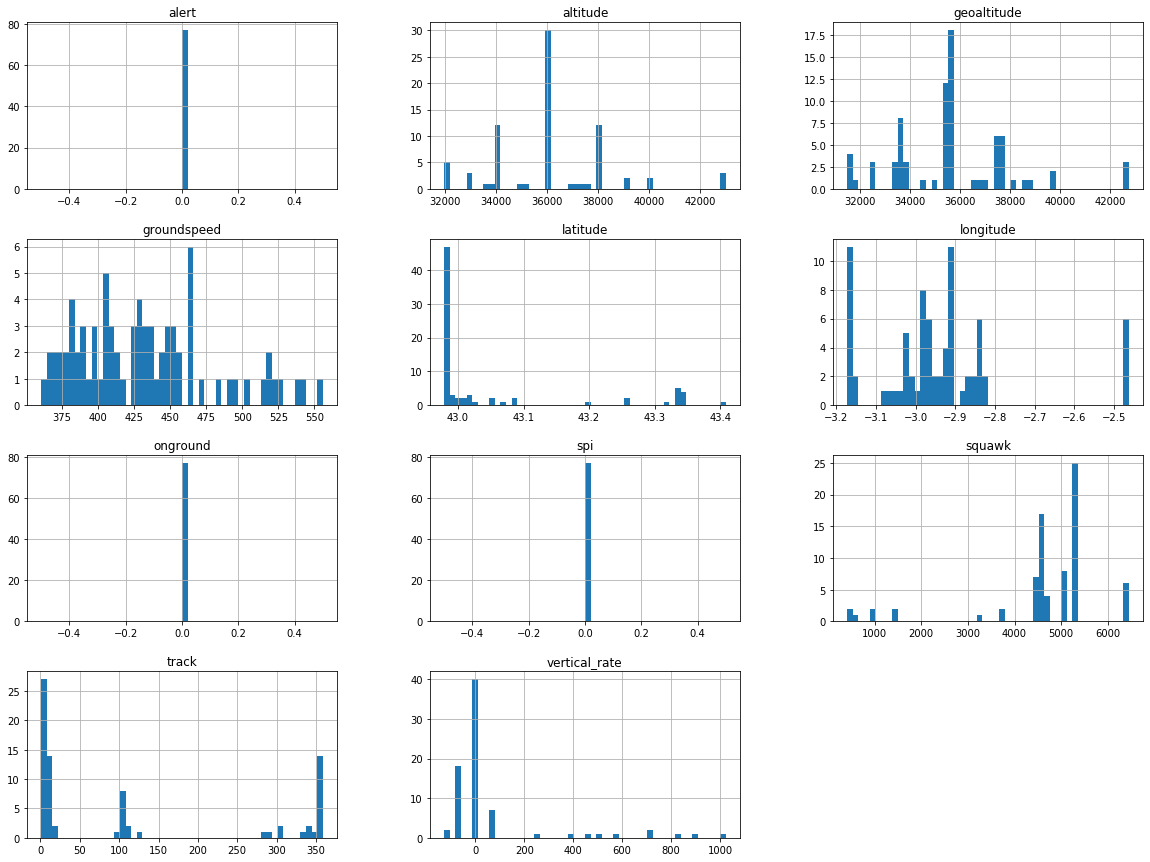

In [24]:
# Ahora vamos a sacar estadísticas de las aeronaves cuando entran al espacio aéreo

%matplotlib inline
import matplotlib.pyplot as plt
BBDD_first_identifier.hist(bins=50, figsize=(20,15))
plt.show()

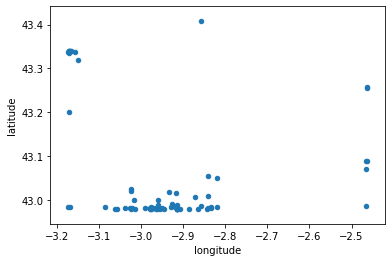

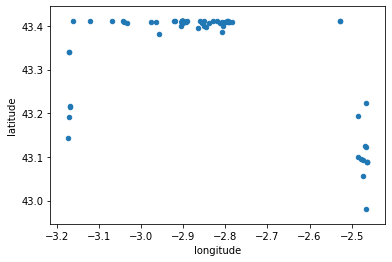

In [25]:
# Vamos a hacer dibujos para ganar perspectiva sobre por donde entran al espacio aéreo
BBDD_first_identifier.plot(kind="scatter", x="longitude", y="latitude")
BBDD_last_identifier.plot(kind = "scatter", x="longitude", y = "latitude")
plt.show()

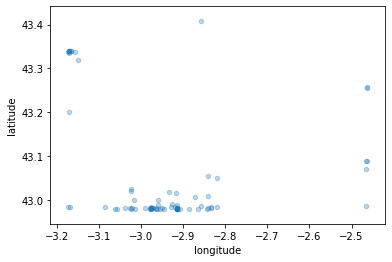

In [26]:
# Ahora vamos a pintar con un degradado
BBDD_first_identifier.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3)
plt.show()

In [27]:
# Vamos a ver si aplicamos el clustering para los air traffic flows y saber juntar flujos que coincidan
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from traffic.core.projection import EuroPP

# Aplicamos el método wrap
Bilbao_unwrapped = Bilbao_4.assign_id().unwrap().eval(max_workers=4)

# Aplicamos el DBSCAN a la parte de unwrapped. Aquí tenemos varios cosas que 
Bilbao_dbscan = Bilbao_unwrapped.clustering(
    nb_samples=15,
    projection=EuroPP(),
    clustering=DBSCAN(eps=0.5, min_samples=5),
    transform=StandardScaler(),
).fit_predict()

In [28]:
# Lo pasamos a un dictionary para que trabajar con ellos
dict(Bilbao_dbscan.groupby(["cluster"]).agg({"flight_id": "nunique"}).flight_id)

Bilbao_dbscan = Bilbao_dbscan.drop('track_unwrapped', axis = 1)
Bilbao_dbscan.data

,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,last_position,latitude,longitude,onground,spi,squawk,timestamp,track,vertical_rate,flight_id,cluster
0,False,38000.0,AAL66,37450.0,539.541006,2019-01-31 07:00:00+00:00,aa8a83,2019-01-31 07:13:40.680000+00:00,43.340459,-3.170602,False,False,3713.0,2019-01-31 07:13:41+00:00,101.872250,0.0,AAL66_000,2
1,False,37975.0,AAL66,37450.0,539.541006,2019-01-31 07:00:00+00:00,aa8a83,2019-01-31 07:13:40.680000+00:00,43.340459,-3.170602,False,False,3713.0,2019-01-31 07:13:42+00:00,101.872250,0.0,AAL66_000,2
2,False,37975.0,AAL66,37425.0,539.541006,2019-01-31 07:00:00+00:00,aa8a83,2019-01-31 07:13:42.375000064+00:00,43.339462,-3.164254,False,False,3713.0,2019-01-31 07:13:43+00:00,101.872250,0.0,AAL66_000,2
3,False,38000.0,AAL66,37425.0,539.541006,2019-01-31 07:00:00+00:00,aa8a83,2019-01-31 07:13:43.747000320+00:00,43.338970,-3.160924,False,False,3713.0,2019-01-31 07:13:44+00:00,101.872250,0.0,AAL66_000,2
4,False,37975.0,AAL66,37425.0,539.541006,2019-01-31 07:00:00+00:00,aa8a83,2019-01-31 07:13:44.407000064+00:00,43.338455,-3.157547,False,False,3713.0,2019-01-31 07:13:45+00:00,101.872250,0.0,AAL66_000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17246,False,7525.0,VLG3981,37700.0,521.624894,2019-01-31 18:00:00+00:00,344693,2019-01-31 18:58:21.456999936+00:00,43.094742,-2.476778,False,False,5012.0,2019-01-31 18:58:25+00:00,122.075242,0.0,VLG3981_076,2
17247,False,7525.0,VLG3981,37700.0,521.624894,2019-01-31 18:00:00+00:00,344693,2019-01-31 18:58:21.456999936+00:00,43.094742,-2.476778,False,False,5012.0,2019-01-31 18:58:26+00:00,122.075242,0.0,VLG3981_076,2
17248,False,7525.0,VLG3981,37700.0,521.624894,2019-01-31 18:00:00+00:00,344693,2019-01-31 18:58:21.456999936+00:00,43.094742,-2.476778,False,False,5012.0,2019-01-31 18:58:27+00:00,122.075242,0.0,VLG3981_076,2
17249,False,7525.0,VLG3981,37700.0,521.624894,2019-01-31 18:00:00+00:00,344693,2019-01-31 18:58:21.456999936+00:00,43.094742,-2.476778,False,False,5012.0,2019-01-31 18:58:28+00:00,122.075242,0.0,VLG3981_076,2


# Preparacion BBDD para conflictos

Para preparar la BBDD necesitamos tener en cuenta que queremos que aparezca y el flujo en el cual se debe calcular la BBDD con la que aprenda el algoritmo de ML.
Queremos obtener una BBDD en la que tenemos información de todos los conflictos. Aquí hay un problema que no sé resolver, y es que en la predicción de trayectorias se le dan un dataset en el cual se toma como base 10 puntos y se predice la trayectoria a futuro con multiples puntos como resultado. Entiendo que eso se hace con una gran muestra de trayectorias y de cada trayectoria se da toda la trayectoria para que aprenda. Yo solamente sé trabajar con una BBDD en la que cada row es un dato, no sé como darle que cada row signifique una trayectoria  en la que cada punto de información se disponga información del viento, tiempo, velocidad, masa, etc.

Este paso sería importante pero como no lo sé hacer lo dejamos para el futuro.
El enfoque que le quiero dar es más sencillo y lo que le proporcionamos como datos son que cada row tiene la información entre un par de aeronaves de tal forma que cuando una entra en el espacio aéreo seleccionado evalúa con el resto de aeronaves que ya hay si se va a producir un conflicto. Para ello en esa row se debe proporcionar sobre la situación en la que se encuentran ambas aeronaves y la label es si habrá un conflicto o no. Esta base de datos no existe por lo que hay que calcularla a partir de las trayectorias que operan las aeronaves. 

Los pasos son los siguientes:

- Paso 1: Pasar el tiempo de origen de todas las trayectorias al mismo instante de tiempo. Esto es necesario ya que la función de calcular la distancia entre aeronaves de Opensky evalúa como se encuentran temporalmente las aeronaves. Esto me dará una muestra grande de trayectorias dentro de un espacio aéreo para evaluar aunque no sea real ya que en un espacio aéreo no ocurren las mismas condiciones de viento o de temperatura a las 8 de la mañana que a las 11 de la noche. No obstante, eso no es un problema ya que lo que quiero es que el algoritmo aprenda a valorar que condiciones se tienen que dar entre un par de aeronaves para que haya un conflicto o no.

- Paso 2: Preparar toda la información que quiero que aparezca en la BBDD: longitud y latitud de la aeronave1, de la aeronave2, distancia relativa entre ambas, rumbo entre ellas en el instante inicial, velocidad relativa entre ambas y rumbo entre sus trayectorias, velocidad vertical relativa entre ambas, diferencia vertical inicial entre ambas, y si se me ocurre alguna mas la incluimos.

- Paso 3: Para la BBDD que dispongo de trayectorias se debe evaluar para cada par de aeronaves que condiciones se dan entre ambas y detectar si se produce un conflicto o no. Aquí deberíamos guardar en un array o columna si se produce conflicto o no (0-1), la distancia mínima que se alcanza, la diferencia de tiempo hasta que se produzca la vulneración de las mínimas de separación.

Con toda esta información se podrá tener una BBDD con la que aplicar las técnicas de ML.

## Empezamos con el Paso 1. Poner todos los tiempo de origen a 0

In [29]:
Bilbao_dbscan.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17251 entries, 0 to 17250
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   alert          17251 non-null  bool               
 1   altitude       17251 non-null  float64            
 2   callsign       17251 non-null  object             
 3   geoaltitude    17251 non-null  float64            
 4   groundspeed    17251 non-null  float64            
 5   hour           17251 non-null  datetime64[ns, UTC]
 6   icao24         17251 non-null  object             
 7   last_position  17251 non-null  datetime64[ns, UTC]
 8   latitude       17251 non-null  float64            
 9   longitude      17251 non-null  float64            
 10  onground       17251 non-null  bool               
 11  spi            17251 non-null  bool               
 12  squawk         17251 non-null  float64            
 13  timestamp      17251 non-null  datetime64[ns, 

In [30]:
import datetime
# Definimos la BBDD que ya tenemos preparada de anteriorida
Bilbao_5 = Bilbao_dbscan

# Para pasar la hora temporal de una aeroanve de toda su trayectoria de la hora normal a una hora, es necesario restarle el valor inicial 
#a toda la muestra
#Lista de flight_id en la BBDD
timestamp = pd.Series([])
listado_aves = Bilbao_5.data.flight_id.unique()
for ave in listado_aves:
    # Seleccionamos la trayectoria de la aeronave y creamos una copia
    tray = Bilbao_5[ave].data
    tray2 = tray
    # Seleccionamos el instante de tiempo inicial
    init_time = tray.timestamp.iloc[0]
    # El instante inicial lo restamos, hay que tener cuidado con que no se convierta en timedelta ya que el formato es datetime
    tray2_timestamp = tray.timestamp - datetime.timedelta(hours = init_time.hour, minutes = init_time.minute, seconds = init_time.second)
    #Los nuevos timestamp los metemos en una columna que más tarde la cambiaremos para que coincida con todos los vuelos de la BBDD
    timestamp = timestamp.append(tray2_timestamp)

# Cambiamos la nueva columna por la anterior de timestamp en la BBDD, con info comprobamos qu emantiene el formato datetime
Bilbao_5.data.timestamp = timestamp
Bilbao_5.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17251 entries, 0 to 17250
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   alert          17251 non-null  bool               
 1   altitude       17251 non-null  float64            
 2   callsign       17251 non-null  object             
 3   geoaltitude    17251 non-null  float64            
 4   groundspeed    17251 non-null  float64            
 5   hour           17251 non-null  datetime64[ns, UTC]
 6   icao24         17251 non-null  object             
 7   last_position  17251 non-null  datetime64[ns, UTC]
 8   latitude       17251 non-null  float64            
 9   longitude      17251 non-null  float64            
 10  onground       17251 non-null  bool               
 11  spi            17251 non-null  bool               
 12  squawk         17251 non-null  float64            
 13  timestamp      17251 non-null  datetime64[ns, 

In [31]:
Bilbao_5.data

,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,last_position,latitude,longitude,onground,spi,squawk,timestamp,track,vertical_rate,flight_id,cluster
0,False,38000.0,AAL66,37450.0,539.541006,2019-01-31 07:00:00+00:00,aa8a83,2019-01-31 07:13:40.680000+00:00,43.340459,-3.170602,False,False,3713.0,2019-01-31 00:00:00+00:00,101.872250,0.0,AAL66_000,2
1,False,37975.0,AAL66,37450.0,539.541006,2019-01-31 07:00:00+00:00,aa8a83,2019-01-31 07:13:40.680000+00:00,43.340459,-3.170602,False,False,3713.0,2019-01-31 00:00:01+00:00,101.872250,0.0,AAL66_000,2
2,False,37975.0,AAL66,37425.0,539.541006,2019-01-31 07:00:00+00:00,aa8a83,2019-01-31 07:13:42.375000064+00:00,43.339462,-3.164254,False,False,3713.0,2019-01-31 00:00:02+00:00,101.872250,0.0,AAL66_000,2
3,False,38000.0,AAL66,37425.0,539.541006,2019-01-31 07:00:00+00:00,aa8a83,2019-01-31 07:13:43.747000320+00:00,43.338970,-3.160924,False,False,3713.0,2019-01-31 00:00:03+00:00,101.872250,0.0,AAL66_000,2
4,False,37975.0,AAL66,37425.0,539.541006,2019-01-31 07:00:00+00:00,aa8a83,2019-01-31 07:13:44.407000064+00:00,43.338455,-3.157547,False,False,3713.0,2019-01-31 00:00:04+00:00,101.872250,0.0,AAL66_000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17246,False,7525.0,VLG3981,37700.0,521.624894,2019-01-31 18:00:00+00:00,344693,2019-01-31 18:58:21.456999936+00:00,43.094742,-2.476778,False,False,5012.0,2019-01-31 00:03:54+00:00,122.075242,0.0,VLG3981_076,2
17247,False,7525.0,VLG3981,37700.0,521.624894,2019-01-31 18:00:00+00:00,344693,2019-01-31 18:58:21.456999936+00:00,43.094742,-2.476778,False,False,5012.0,2019-01-31 00:03:55+00:00,122.075242,0.0,VLG3981_076,2
17248,False,7525.0,VLG3981,37700.0,521.624894,2019-01-31 18:00:00+00:00,344693,2019-01-31 18:58:21.456999936+00:00,43.094742,-2.476778,False,False,5012.0,2019-01-31 00:03:56+00:00,122.075242,0.0,VLG3981_076,2
17249,False,7525.0,VLG3981,37700.0,521.624894,2019-01-31 18:00:00+00:00,344693,2019-01-31 18:58:21.456999936+00:00,43.094742,-2.476778,False,False,5012.0,2019-01-31 00:03:57+00:00,122.075242,0.0,VLG3981_076,2


Con estos cambios hemos conseguido que la BBDD todas las aeronaves entren en el espacio aéreo en el mismo instante t=0.

# OJO QUE HAY UN FALLO. EN LA BBDD QUE HE UTILIZADO SOLAMENTE HAY UN DÍA, ES DECIR, EN LA PRÓXIMA BBDD EN LA QUE HAYA VARIOS DÍAS HABRÁ QUE MODIFICAR PARA QUE TODAS LAS AERONAVES OPEREN EL MISMO DÍA

## Paso 2. Modificar la BBDD para que cada row contenga la información de cada conflicto o potencial conflicto. 
Existen una serie de variables que quiero que sean los features del ML algorithm. 

In [32]:
#El primer paso es generar todas las parejas de aeronaves que quiero que me constituyan parte de la BBDD
def parejas(BBDD):
    pairs = []
    listado_aves = BBDD.data.flight_id.unique()
    for ave1 in listado_aves:
        for ave2 in listado_aves:
            if ave1 == ave2:
                pass
            else:
                pairs.append([ave1, ave2])
    return pairs

In [33]:
# Aplicamos la función con la BBDD que nos interesa y denominamos al vector pairs
pairs = pd.DataFrame(parejas(Bilbao_5))
# Le incluimos nombre a las columnas ave1 y ave 2
pairs.columns = ["ave1", "ave2"]


Este DataFrame pairs va a ser las primeras columnas de la BBDD para el algoritmo de ML

El siguiente paso es introducir todos los features de las aeronaves de acuerdo con los datos de las aeronaves de la BBDD.

Vamos a empezar con introducir la longitud y latitud de cada aeronave en la BBDD

In [34]:
# CCreamos un DataFrame para las ave1 de las parejas de aves y otro para las aves2, luego las juntaremos
# Generamos unas matrices vacías para facilitar el proceso
Datos_ave1 = Bilbao_5.data.iloc[0:0]
Datos_ave2 = Bilbao_5.data.iloc[0:0]
for index, row in pairs.iterrows():
    # Seleccionamos cada una de las aeronaves que aparecen en las parejas
    tray_ave1 = Bilbao_5[row['ave1']].data
    tray_ave2 = Bilbao_5[row['ave2']].data
    #Obtenemos los datos de entrada de cada aeronave
    init_values_ave1 = tray_ave1.iloc[0]
    init_values_ave2 = tray_ave2.iloc[0]

    # Metemos esta información en un DataFrame para cada aeronave
    Datos_ave1 = Datos_ave1.append(init_values_ave1)
    Datos_ave2 = Datos_ave2.append(init_values_ave2)


In [35]:
Datos_ave2

,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,last_position,latitude,longitude,onground,spi,squawk,timestamp,track,vertical_rate,flight_id,cluster
233,False,37625.0,AEA13DZ,37350.0,434.355470,2019-01-31 14:00:00+00:00,34604d,2019-01-31 14:56:15.431000064+00:00,42.979028,-2.944336,False,False,5327.0,2019-01-31 00:00:00+00:00,9.006915,448.0,AEA13DZ_001,-1
448,False,37000.0,AEA98GX,36675.0,415.832540,2019-01-31 08:00:00+00:00,34604d,2019-01-31 08:10:43.772000+00:00,42.979568,-2.977167,False,False,5325.0,2019-01-31 00:00:00+00:00,5.381547,704.0,AEA98GX_002,0
673,False,33725.0,ANE8548,33350.0,452.805307,2019-01-31 20:00:00+00:00,3453d3,2019-01-31 20:07:30.150000128+00:00,42.999481,-2.960368,False,False,1456.0,2019-01-31 00:00:00+00:00,3.418473,704.0,ANE8548_004,-1
880,False,34000.0,AFR53UV,33650.0,383.333727,2019-01-31 10:00:00+00:00,3991e4,2019-01-31 10:01:15.584000+00:00,42.980424,-2.954668,False,False,1461.0,2019-01-31 00:00:00+00:00,2.392166,0.0,AFR53UV_003,0
1125,False,36025.0,BAW2633,35625.0,429.465576,2019-01-31 16:00:00+00:00,406b5b,2019-01-31 16:26:24.150000128+00:00,43.016316,-2.917262,False,False,4562.0,2019-01-31 00:00:00+00:00,357.330801,0.0,BAW2633_005,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15624,False,32000.0,VLG15SR,31500.0,504.623186,2019-01-31 18:00:00+00:00,343386,2019-01-31 18:59:46.568999936+00:00,43.339645,-3.167192,False,False,5024.0,2019-01-31 00:00:00+00:00,101.777552,0.0,VLG15SR_071,2
15880,False,33000.0,VLG15YE,32600.0,381.494100,2019-01-31 07:00:00+00:00,3424d4,2019-01-31 07:01:22.942000128+00:00,43.089386,-2.464770,False,False,410.0,2019-01-31 00:00:00+00:00,302.148662,-64.0,VLG15YE_072,-1
16213,False,34000.0,VLG16FH,33575.0,513.841944,2019-01-31 10:00:00+00:00,346088,2019-01-31 10:13:13.152999936+00:00,43.340459,-3.170602,False,False,5066.0,2019-01-31 00:00:00+00:00,101.791031,-64.0,VLG16FH_073,2
16455,False,32975.0,VLG3864,32600.0,368.781460,2019-01-31 17:00:00+00:00,343386,2019-01-31 17:21:01.005000192+00:00,42.986243,-2.466758,False,False,6345.0,2019-01-31 00:00:00+00:00,294.341090,-128.0,VLG3864_074,-1


In [36]:
# De este modo hemos obtenido dos DataFrame con la información de cada ave siguiendo el orden.
# El siguiente paso es eliminar todas las columnas que no me interesan
columnas = ["alert", "callsign", "hour", "icao24", "last_position", "onground", "spi", "squawk"]
Datos_fil_ave1 = Datos_ave1.drop(columns = columnas)
Datos_fil_ave2 = Datos_ave2.drop(columns = columnas)

# Tenemos que reiniciar los indices para que coincidan
Datos_fil_ave2.index = range(Datos_fil_ave2.shape[0])
Datos_fil_ave1.index = range(Datos_fil_ave1.shape[0])

# Lo vamos ambas en el mismo dataFrame y lo unimos finalmente con el pairs que contienen los pares de aeronaves
Datos_fil = Datos_fil_ave1.join(Datos_fil_ave2, lsuffix= '_1', rsuffix = '_2')
Datos_fil =pairs.join(Datos_fil)

# Una vez comproado que funcion vamos a eliminar las columans de flight_id_1 y flight_id_2 para que no se repitan
Datos_fil = Datos_fil.drop(columns = ['flight_id_1', 'flight_id_2'])

In [37]:
Datos_fil

,ave1,ave2,altitude_1,geoaltitude_1,groundspeed_1,latitude_1,longitude_1,timestamp_1,track_1,vertical_rate_1,cluster_1,altitude_2,geoaltitude_2,groundspeed_2,latitude_2,longitude_2,timestamp_2,track_2,vertical_rate_2,cluster_2
0,AAL66_000,AEA13DZ_001,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,2,37625.0,37350.0,434.355470,42.979028,-2.944336,2019-01-31 00:00:00+00:00,9.006915,448.0,-1
1,AAL66_000,AEA98GX_002,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,2,37000.0,36675.0,415.832540,42.979568,-2.977167,2019-01-31 00:00:00+00:00,5.381547,704.0,0
2,AAL66_000,ANE8548_004,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,2,33725.0,33350.0,452.805307,42.999481,-2.960368,2019-01-31 00:00:00+00:00,3.418473,704.0,-1
3,AAL66_000,AFR53UV_003,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,2,34000.0,33650.0,383.333727,42.980424,-2.954668,2019-01-31 00:00:00+00:00,2.392166,0.0,0
4,AAL66_000,BAW2633_005,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,2,36025.0,35625.0,429.465576,43.016316,-2.917262,2019-01-31 00:00:00+00:00,357.330801,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,VLG3981_076,VLG15SR_071,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,2,32000.0,31500.0,504.623186,43.339645,-3.167192,2019-01-31 00:00:00+00:00,101.777552,0.0,2
5848,VLG3981_076,VLG15YE_072,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,2,33000.0,32600.0,381.494100,43.089386,-2.464770,2019-01-31 00:00:00+00:00,302.148662,-64.0,-1
5849,VLG3981_076,VLG16FH_073,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,2,34000.0,33575.0,513.841944,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.791031,-64.0,2
5850,VLG3981_076,VLG3864_074,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,2,32975.0,32600.0,368.781460,42.986243,-2.466758,2019-01-31 00:00:00+00:00,294.341090,-128.0,-1


Una vez que tenemos la BBDD con cada pareja de aeronaves tenemos que proporcionar toda la información que queremos a partir de la constitución de varias variables, por ejemplo velocidad relativa, curso relativo, etc.

Una vez que hemos calculado la distancia entre todos los pares de aeronaves, el resto de códigos para calcular las variables se calculan siguiendo el mismo proceso hasta obtener la matriz que queramos.

El siguiente paso será calcular la dirección relativa entre ambas

In [38]:
# Código para calcular la dirección relativa entre ambas
# Empezamos con el calculo de la distancia entre dos puntos, extraemos las funciones que necesitamos
from geographiclib.geodesic import Geodesic

# Toda la información que necesitamos para ssaber como funciona es https://living-sun.com/es/python/693845-geopy-calculating-gps-heading-bearing-python-python-3x-gps-geo-geopy.html
acimut = []
dist2 = []
# Tenemos que calcular para cada pareja de aeronaves, es deir para cada fila:
for index, row in Datos_fil.iterrows():
    # Seleccionamos cada una de las posiciones que aparecen en cada fila de aeronaves, en este caso en º y no en radianes
    lat1, lon1 = row['latitude_1'], row['longitude_1']
    lat2, lon2 = row['latitude_2'], row['longitude_2']
    # Aplicamos la formula que nos dice y que nos proporciona todos los datos
    datos = Geodesic.WGS84.Inverse(lat1, lon1, lat2, lon2)
    # Calculamos los valores de acimut (azi1) y de separacion (dist2)
    dist2.append(datos['s12']/1852)
    acimut.append(datos['azi1'])
    
# La variable distance nos permite obtener la distancia en el instante inicial en el que entran las aeronaves (en NM)
# Introducimos la variable distance en el DataFrame
Datos_fil['Init separation'] = dist2
Datos_fil['Init acimut'] = acimut
Datos_fil

,ave1,ave2,altitude_1,geoaltitude_1,groundspeed_1,latitude_1,longitude_1,timestamp_1,track_1,vertical_rate_1,...,geoaltitude_2,groundspeed_2,latitude_2,longitude_2,timestamp_2,track_2,vertical_rate_2,cluster_2,Init separation,Init acimut
0,AAL66_000,AEA13DZ_001,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,...,37350.0,434.355470,42.979028,-2.944336,2019-01-31 00:00:00+00:00,9.006915,448.0,-1,23.849592,155.300901
1,AAL66_000,AEA98GX_002,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,...,36675.0,415.832540,42.979568,-2.977167,2019-01-31 00:00:00+00:00,5.381547,704.0,0,23.255627,158.509750
2,AAL66_000,ANE8548_004,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,...,33350.0,452.805307,42.999481,-2.960368,2019-01-31 00:00:00+00:00,3.418473,704.0,-1,22.440654,155.639011
3,AAL66_000,AFR53UV_003,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,...,33650.0,383.333727,42.980424,-2.954668,2019-01-31 00:00:00+00:00,2.392166,0.0,0,23.587378,156.221898
4,AAL66_000,BAW2633_005,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,...,35625.0,429.465576,43.016316,-2.917262,2019-01-31 00:00:00+00:00,357.330801,0.0,-1,22.400455,150.144479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,VLG3981_076,VLG15SR_071,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,...,31500.0,504.623186,43.339645,-3.167192,2019-01-31 00:00:00+00:00,101.777552,0.0,2,0.451995,-74.852697
5848,VLG3981_076,VLG15YE_072,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,...,32600.0,381.494100,43.089386,-2.464770,2019-01-31 00:00:00+00:00,302.148662,-64.0,-1,33.836487,115.878285
5849,VLG3981_076,VLG16FH_073,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,...,33575.0,513.841944,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.791031,-64.0,2,0.608912,-74.086767
5850,VLG3981_076,VLG3864_074,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,...,32600.0,368.781460,42.986243,-2.466758,2019-01-31 00:00:00+00:00,294.341090,-128.0,-1,36.928889,124.573877


In [39]:
#El siguiente paso es calcular la diferencia de velocidades entre ellos y la diferencia de track entre ambos, es decir, hacia donde vuelan
# Toda la información que necesitamos para ssaber como funciona es https://living-sun.com/es/python/693845-geopy-calculating-gps-heading-bearing-python-python-3x-gps-geo-geopy.html
from math import radians, sqrt, cos, sin

Var_vel_mod = []    # Variación de la velocidad en módulo por cada par de aeronaves
Var_track = []    # Variacion del track entre ambas aeronaves
# Tenemos que calcular para cada pareja de aeronaves, es deir para cada fila:
for index, row in Datos_fil.iterrows():
    # Seleccionamos cada una de las posiciones que aparecen en cada fila de aeronaves, en este caso en º y no en radianes
    vel1, vel2 = row['groundspeed_1'], row['groundspeed_2']
    track1, track2 = row['track_1'], row['track_2']
    # Calculamos la variación del track de la ave 1 con respecto a la 2
    Var_angle = track1 - track2
    # Calculamos la variación de la velocidad en módulo
    vel1_x, vel1_y = vel1*cos(radians(90-track1)), vel1 * sin(radians(90-track1))
    vel2_x, vel2_y = vel2*cos(radians(90-track2)), vel2 * sin(radians(90-track2))
    Var_vel = sqrt((vel1_x - vel2_x)**2 + (vel1_y - vel2_y)**2)
    # Introducimos los valores de velocidad relativa en módulo y de track
    Var_vel_mod.append(Var_vel)
    Var_track.append(Var_angle)
    
# La variable distance nos permite obtener la distancia en el instante inicial en el que entran las aeronaves (en NM)
# Introducimos la variable distance en el DataFrame
Datos_fil['Var GS Module'] = Var_vel_mod
Datos_fil['Var Track'] = Var_track


In [40]:
# Código para calcular la diferencia de altitudes y velocidad vertical entre las aeronaves al entrar

Var_altitude = []    # Variación de la velocidad en módulo por cada par de aeronaves
Var_Vertical_speed = []    # Variacion del track entre ambas aeronaves
# Tenemos que calcular para cada pareja de aeronaves, es deir para cada fila:
for index, row in Datos_fil.iterrows():
    # Seleccionamos cada una de las posiciones que aparecen en cada fila de aeronaves
    alt1, alt2 = row['altitude_1'], row['altitude_2']
    hspeed_1, hspeed_2 = row['vertical_rate_1'], row['vertical_rate_2']
    # Calculamos la variación de altitude y de velocidad vertical
    Var_alt = alt1 - alt2
    Var_speed = hspeed_1 - hspeed_2
    # Introducimos los valores de altitud y de velocidad relativa
    Var_altitude.append(Var_alt)
    Var_Vertical_speed.append(Var_speed)
    
# Introducimos las variables de variación de altitud y de vertical speed
Datos_fil['Var init altitude'] = Var_altitude
Datos_fil['Var Vertical speed'] = Var_Vertical_speed

In [41]:
Datos_fil.head()

,ave1,ave2,altitude_1,geoaltitude_1,groundspeed_1,latitude_1,longitude_1,timestamp_1,track_1,vertical_rate_1,...,timestamp_2,track_2,vertical_rate_2,cluster_2,Init separation,Init acimut,Var GS Module,Var Track,Var init altitude,Var Vertical speed
0,AAL66_000,AEA13DZ_001,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.87225,0.0,...,2019-01-31 00:00:00+00:00,9.006915,448.0,-1,23.849592,155.300901,709.365301,92.865335,375.0,-448.0
1,AAL66_000,AEA98GX_002,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.87225,0.0,...,2019-01-31 00:00:00+00:00,5.381547,704.0,0,23.255627,158.509750,717.457393,96.490703,1000.0,-704.0
2,AAL66_000,ANE8548_004,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.87225,0.0,...,2019-01-31 00:00:00+00:00,3.418473,704.0,-1,22.440654,155.639011,753.637193,98.453777,4275.0,-704.0
3,AAL66_000,AFR53UV_003,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.87225,0.0,...,2019-01-31 00:00:00+00:00,2.392166,0.0,0,23.587378,156.221898,711.462666,99.480084,4000.0,0.0
4,AAL66_000,BAW2633_005,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.87225,0.0,...,2019-01-31 00:00:00+00:00,357.330801,0.0,-1,22.400455,150.144479,769.352310,-255.458550,1975.0,0.0


Pues ya hemos terminado de introducir todos los datos necesarios para la BBDD como inputs, habrá que quitar datos ya que no todos nos interesan, la propuest para quitarlos es ave1, ave2, altitude 2 y geoaltitude 2( las de 1 no habría que quitarlas ya que creo que genera un problema el aittude si quitamos el geoaltitutde), groundspeed habría que quitar las dos, la latitude1 y longitude 1 habría que dejarlo como referencia, el timestamp_1 y _2 habría que quitarlos así como el vertical_rate1 y 2 y el track1 y 2

No obstante todos esto lo dejamos para más adelante cuando tengamos toda la BBDD.

## .2 Introducir las labels
Bien, el último paso será introducir las labels, en este caso será introducir safety metric como, hay conflicto, distancia al conflicto, minima de separación alcanzada o tiempo al conflicto. No sé cuales podremos comprobar ya que hay que distinguir entre las que son de regresión y las que son de clasificación (conflicto. Pero si tenemos una, el resto es obtener un modelo distinto para cada label. Entonces habría que obtener todos estos datos para cada par de aeronaves. 

Habría que considerar todas aquellas aeronaves que se encuentran a menos de 10 NM  y 2000 ft (o un valor a definir) y para estas se calculan todos los indicadores anteriores. 
El resto de las aeronaves habría que introducir un 0 en conflicto (Un 1 significa que hay vulneración de la mínima de separación), y poner valores los valores límites de 10 NM y 2000 ft (esto podría generar problemas pero no lo sabremos hasta que corramos el código). En algún libro o diapositiva o módulo he leido que todos aquellos valores que se encuentran en el límite, pueden desvirtuar la muestra y que habría que quitarlos. 

Los pasos a seguir son los siguientes:
1. Detectamos todos los pares de aeronaves que se cruzan con menos de 10 nm y 2000 ft.
2. Calculamos todos los indicadores para cada par de aeronave
3. Rellenamos toda la matriz con los valores límites como hemos descrito.
4. Introducimos los indicadores obtenidos para cada par de aeronaves


In [42]:
# Detectamos todos lo spares de aeronaves que se cruzan con unos valores de menos de 10 NM y 2000 ft.
# Para ello el mejor uso que podemos hacer es la función closest point of approach del código

# La última BBDD en la que tenemos en formato traffic es la de Bilbao_5 y hay que tener cuidado en seleccionar correctamente la última BBDD
CPA = Bilbao_5.closest_point_of_approach(lateral_separation = 10*1852, vertical_separation = 2000)

In [43]:
# Ojo¡¡¡ el resultado de la distancia lateral está en NM y no en m.
CPA

,timestamp,latitude_x,longitude_x,altitude_x,icao24_x,callsign_x,flight_id_x,latitude_y,longitude_y,altitude_y,icao24_y,callsign_y,flight_id_y,lateral,vertical
0,2019-01-31 00:00:01+00:00,42.986710,-2.927601,36025.0,406fda,EZY18LH,EZY18LH_018,42.979111,-3.023412,34000.0,34520f,IBE3180,IBE3180_033,4.244141,2025.0
1,2019-01-31 00:00:02+00:00,42.988804,-2.927660,36025.0,406fda,EZY18LH,EZY18LH_018,42.979111,-3.023412,34000.0,34520f,IBE3180,IBE3180_033,4.256805,2025.0
2,2019-01-31 00:00:03+00:00,42.988804,-2.927660,36025.0,406fda,EZY18LH,EZY18LH_018,42.979111,-3.023412,34000.0,34520f,IBE3180,IBE3180_033,4.256805,2025.0
3,2019-01-31 00:00:04+00:00,42.988804,-2.927660,36025.0,406fda,EZY18LH,EZY18LH_018,42.979111,-3.023412,34000.0,34520f,IBE3180,IBE3180_033,4.256805,2025.0
4,2019-01-31 00:00:05+00:00,42.988804,-2.927660,36025.0,406fda,EZY18LH,EZY18LH_018,42.988358,-3.020921,34000.0,34520f,IBE3180,IBE3180_033,4.106981,2025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,2019-01-31 00:03:35+00:00,43.115479,-2.521937,38000.0,344693,VLG3981,VLG3981_076,43.225113,-2.481186,34000.0,343386,VLG3865,VLG3865_075,6.815701,4000.0
214,2019-01-31 00:03:36+00:00,43.115479,-2.521937,38000.0,344693,VLG3981,VLG3981_076,43.225113,-2.481186,34000.0,343386,VLG3865,VLG3865_075,6.815701,4000.0
215,2019-01-31 00:03:37+00:00,43.115479,-2.521937,38000.0,344693,VLG3981,VLG3981_076,43.225113,-2.481186,34000.0,343386,VLG3865,VLG3865_075,6.815701,4000.0
216,2019-01-31 00:03:38+00:00,43.115479,-2.521937,38000.0,344693,VLG3981,VLG3981_076,43.223557,-2.471988,34000.0,343386,VLG3865,VLG3865_075,6.844183,4000.0


In [101]:
# El DATAFRAME CPA tiene la información de todas las aeronaves que se cruzan a menos de 10NM y a menos de 2000 ft en algún punto

# Definimos la función que determina si hay un conflicto, tipo booleana 0 (no hay conflicto) y 1 (sí hay conflicto)
def conflict_detection(CPA_datos):
    # Obtengo las filas en las que la mínima de separacion longitudinal es inferior a 5 MN
    rows_lon = CPA_datos['lateral'] < 5
    CPA_datos_lon = CPA_datos[rows_lon]
    CPA_datos_lon
    # De estas filas obtengo las que se cumple que es menor de 1000 ft la vertical
    rows_vert = CPA_datos_lon['vertical'] < 1000
    CPA_conf = CPA_datos_lon[rows_vert]
    if len(CPA_conf) > 0:
        conf = 1     # Nos da un 1 si hay alguna fila que cumpla ambas condiciones
        Minsep = min(CPA_conf['lateral'])
        # Para calcular el tiempo cogemos el primer instante en el que se genera el conflicto ya que la aeronave entra en el 0000, 
        # En el caso de que la aeronave no entrara en el instante 00 habría que restarlo
        # hora_original = Un problema ya que hay que coger el primer instante en el que entran las aeronaves
        dif_segundos = CPA_conf.iloc[0].timestamp.hour*3600 + CPA_conf.iloc[0].timestamp.minute*60 + CPA_conf.iloc[0].timestamp.second
        Timetoconf = dif_segundos
    else:
        conf = 0     # Nos da un 0 si no hay ninguna fila que cumpla una vulneración de ambas mínimas de separación
        # En el caso de que no haya conflictos ponemos un 10, no podemos poner la minima distancia ya  que quizá dos aeronaves se cruzan 
        #a 3 NM pero con una vertical de 30000 ft y por lo tanto se vuelve loco el algoritmo, también se podría pensar en ponerlo
        Minsep = 10
        # Lo mismo ocurrre con el tiempo
        Timetoconf = 10000 # Hemos puesto 10000 segundos pero sin saber realmente como puede afectar, habría que analizarlo
    return conf, Minsep, Timetoconf


In [102]:
# Tenemos que generar un DataFrame para cada par de aeronaves, teneos el flight_id_x que será la correspondiente con ave_1
label_ave1, label_ave2 = pd.Series(CPA["flight_id_x"].unique()), pd.Series(CPA["flight_id_y"].unique())
pairs_CPA = pd.DataFrame({'flight_id_x': label_ave1, 'flight_id_y': label_ave2})

conflict = []    # Matriz en la que vamos a guardar si hay conflicto o no
TTC = []         # Matriz en la que vamos a guardar el tiempo al conflicto
MinDis = []      # Matriz en la que vamos a guardar la distancia mínima alcanzada entre aeronaves

# Para cada una de las parejas tenemos que obtener la parte del CPA que le corrresponde:
for index, row in pairs_CPA.iterrows():
    # Sacamos los nombres de cada par de aeronaves
    ave1, ave2 = row['flight_id_x'], row['flight_id_y']
    CPA_1 = CPA[CPA['flight_id_x'] == ave1]
    CPA_datos = CPA_1[CPA_1['flight_id_y'] == ave2]
    # CPA_datos contiene toda la información para un par de aeronaves con conflicto y le aplicamos la función conflicto
    conf, Minsep, Timetoconf = conflict_detection(CPA_datos)
    conflict.append(conf), MinDis.append(Minsep), TTC.append(Timetoconf)

# Introducimos las variables de variación de altitud y de vertical speed
pairs_CPA['Conflicto'] = conflict
pairs_CPA['MinDis'] = MinDis
pairs_CPA['Timetoconf'] = TTC

In [103]:
pairs_CPA

,flight_id_x,flight_id_y,Conflicto,MinDis,Timetoconf
0,EZY18LH_018,IBE3180_033,0,10.000000,10000
1,BAW457_007,RYR4Z_055,0,10.000000,10000
2,RYR6N_059,VLG3864_074,0,10.000000,10000
3,RYR3JZ_053,EZY61JF_025,1,3.189774,60
4,IBK6054_040,AAL66_000,0,10.000000,10000
...,...,...,...,...,...
72,EZY48ED_022,VLG15NT_070,0,10.000000,10000
73,VLG15YE_072,BAW74_014,0,10.000000,10000
74,EJM410_016,AEA13DZ_001,0,10.000000,10000
75,N838SC_043,N838SC_043,0,10.000000,10000


In [104]:
# Una vez que tenemos todas aquellas aeronaves que son pareja y tienen los datos hay que incluir los indicadores
Datos_fil_con = Datos_fil
# Lo primero es generar una columna nueva que se llame conflictos en los datos filtrados que se rellene de 0
Datos_fil_con["Conflicto"] = 0
# Para la distancia ponemos un 10 como el peor caso
Datos_fil_con["MinDis"] = 10
# Para el tiempo ponemos un 10000 como hemos puesto en los otros para que no genere problema 
Datos_fil_con["Timetoconf"] = 10000

#Hay que construir una función que detecte las parejas de aeronaves que tienen un conflicto y cambien el 0 a un 1

In [105]:
Datos_fil_con

,ave1,ave2,altitude_1,geoaltitude_1,groundspeed_1,latitude_1,longitude_1,timestamp_1,track_1,vertical_rate_1,...,cluster_2,Init separation,Init acimut,Var GS Module,Var Track,Var init altitude,Var Vertical speed,Conflicto,MinDis,Timetoconf
0,AAL66_000,AEA13DZ_001,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,...,-1,23.849592,155.300901,709.365301,92.865335,375.0,-448.0,0,10,10000
1,AAL66_000,AEA98GX_002,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,...,0,23.255627,158.509750,717.457393,96.490703,1000.0,-704.0,0,10,10000
2,AAL66_000,ANE8548_004,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,...,-1,22.440654,155.639011,753.637193,98.453777,4275.0,-704.0,0,10,10000
3,AAL66_000,AFR53UV_003,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,...,0,23.587378,156.221898,711.462666,99.480084,4000.0,0.0,0,10,10000
4,AAL66_000,BAW2633_005,38000.0,37450.0,539.541006,43.340459,-3.170602,2019-01-31 00:00:00+00:00,101.872250,0.0,...,-1,22.400455,150.144479,769.352310,-255.458550,1975.0,0.0,0,10,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,VLG3981_076,VLG15SR_071,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,...,2,0.451995,-74.852697,32.449933,2.469143,5975.0,-64.0,0,10,10000
5848,VLG3981_076,VLG15YE_072,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,...,-1,33.836487,115.878285,898.950835,-197.901967,4975.0,0.0,0,10,10000
5849,VLG3981_076,VLG16FH_073,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,...,2,0.608912,-74.086767,26.570638,2.455665,3975.0,0.0,0,10,10000
5850,VLG3981_076,VLG3864_074,37975.0,37600.0,528.245698,43.337677,-3.157228,2019-01-31 00:00:00+00:00,104.246695,-64.0,...,-1,36.928889,124.573877,893.659119,-190.094395,5000.0,64.0,0,10,10000


In [155]:
#Hay que construir una función que detecte las parejas de aeronaves que tienen un conflicto y cambien el 0 a un 1, así como con la distancia y el tiempo
def mod_conflictos(pairs_CPA, Datos_fil_con):
    # identificamos las filas que tienen conflicto
    Datos_final = Datos_fil_con
    rows_conflict = pairs_CPA['Conflicto'] == 1
    pairs_CPA_conflict = pairs_CPA[rows_conflict]
    
    # En el caso de que haya algún conflicto hay que cambiar los 0 por 1, y las distancias por sus valores 
    if len(pairs_CPA_conflict) > 0:
        i = 0
        for index, rows_conflict in pairs_CPA_conflict.iterrows():
            # identifico las aeronaves que tienen conflicto
            ave1_conflict, ave2_conflict = rows_conflict['flight_id_x'], rows_conflict['flight_id_y']
            # Obtenemos la row en la cual hay conflicto
            Datos_fil_con_ave1 = Datos_fil_con[Datos_fil_con['ave1'] == ave1_conflict]
            Datos_fil_con_ave1_ave2 = Datos_fil_con_ave1[Datos_fil_con_ave1['ave2'] == ave2_conflict]
            print(Datos_fil_con_ave1_ave2.index)
            # Identificados la row en la que hay conflicto, tenemos que cambiar el 1 por el 0
            Datos_final['Conflicto'][Datos_fil_con_ave1_ave2.index] = 1
            # Ahora calculamos la mínima distancia que le ocurre a este
            Minsep = pairs_CPA_conflict['MinDis'].iloc[i]
            Datos_final['MinDis'][Datos_fil_con_ave1_ave2.index] = Minsep
            # Lo mismo para el tiempo
            TTC = pairs_CPA_conflict['Timetoconf'].iloc[i]
            Datos_final['Timetoconf'][Datos_fil_con_ave1_ave2.index] = TTC
            # Pongo un contador para las matrices de distancia y tiempo
            i = i + 1
    else:
        Datos_final = Datos_fil_con
    
    return Datos_final

In [156]:
# Aplicamos la función de conflictos para introducir los valores en 0 y 1
BBDD = mod_conflictos(pairs_CPA, Datos_fil_con)
# Una vez introducidos los conflictos comprobamos que estas filas lo cumplen
BBDD.loc[(BBDD['Conflicto'] == 1)]

Int64Index([4053], dtype='int64')
Int64Index([308], dtype='int64')
Int64Index([441], dtype='int64')
Int64Index([4458], dtype='int64')
Int64Index([2232], dtype='int64')
Int64Index([4293], dtype='int64')
Int64Index([1937], dtype='int64')
Int64Index([4876], dtype='int64')
Int64Index([3770], dtype='int64')
Int64Index([2906], dtype='int64')
Int64Index([5156], dtype='int64')
Int64Index([1635], dtype='int64')
Int64Index([3552], dtype='int64')
Int64Index([3122], dtype='int64')
Int64Index([4956], dtype='int64')
Int64Index([1078], dtype='int64')


,ave1,ave2,altitude_1,geoaltitude_1,groundspeed_1,latitude_1,longitude_1,timestamp_1,track_1,vertical_rate_1,...,cluster_2,Init separation,Init acimut,Var GS Module,Var Track,Var init altitude,Var Vertical speed,Conflicto,MinDis,Timetoconf
308,AFR53UV_003,BAW2633_005,34000.0,33650.0,383.333727,42.980424,-2.954668,2019-01-31 00:00:00+00:00,2.392166,0.0,...,-1,2.710687,37.402263,58.412277,-354.938634,-2025.0,0.0,1,2.749961,70.0
441,BAW2633_005,RYR8AD_062,36025.0,35625.0,429.465576,43.016316,-2.917262,2019-01-31 00:00:00+00:00,357.330801,0.0,...,-1,3.351167,96.502898,55.226757,352.720151,-1975.0,0.0,1,3.384072,2.0
1078,BAW74_014,BAW78_015,36000.0,35450.0,427.094468,43.257224,-2.463226,2019-01-31 00:00:00+00:00,343.262207,0.0,...,-1,0.062224,172.673549,4.472132,0.101352,0.0,0.0,1,0.010398,1.0
1635,EZY43EZ_021,IBK6054_040,38000.0,37475.0,395.544852,42.982286,-2.950352,2019-01-31 00:00:00+00:00,9.605204,0.0,...,-1,3.963310,-55.076986,63.245499,-3.389413,2000.0,0.0,1,4.222697,93.0
1937,EZY61JF_025,IBK2403_038,36000.0,35775.0,406.109240,42.985405,-2.834538,2019-01-31 00:00:00+00:00,4.236395,0.0,...,1,3.562950,-86.238956,56.435755,-352.878461,0.0,0.0,1,3.562950,1.0
2232,EZY78UT_029,EZY73LG_028,36025.0,35700.0,379.347797,42.985336,-3.086264,2019-01-31 00:00:00+00:00,345.341001,0.0,...,-1,3.234635,73.707438,200.489228,333.037600,-25.0,0.0,1,3.236539,1.0
2906,IBK2403_038,EZY18LH_018,36000.0,35750.0,377.478150,42.989273,-2.915273,2019-01-31 00:00:00+00:00,357.114855,0.0,...,-1,0.602748,-116.428130,55.901651,-1.691655,-25.0,-64.0,1,0.397518,1.0
3122,IBS3714_041,BAW455_006,34000.0,33550.0,390.661921,42.980301,-2.977614,2019-01-31 00:00:00+00:00,5.287377,0.0,...,0,0.138160,127.836577,74.168662,0.226868,-2025.0,64.0,1,2.119996,122.0
3552,RAM716X_046,RYR5993_057,36000.0,35750.0,405.493176,42.978841,-2.914712,2019-01-31 00:00:00+00:00,357.172875,0.0,...,-1,2.117811,-89.620981,91.005416,347.253477,0.0,64.0,1,0.041086,1.0
3770,RYR22MM_049,RAM716X_046,35200.0,35000.0,403.698797,42.981171,-2.977103,2019-01-31 00:00:00+00:00,5.258676,576.0,...,1,2.751438,92.889402,57.078843,-351.914199,-800.0,576.0,1,0.027622,1.0


In [65]:
# Generamos una nueva BBDD
BBDD_2 = BBDD

In [66]:
# De la BBDD tenemos que eliminar las columnas que no queremos que aparezca para trabajar con el ML
var_eliminar = ['ave1', 'ave2', 'groundspeed_1', 'timestamp_1', 'vertical_rate_1', 'track_1', 'altitude_2', 'geoaltitude_2',
                'latitude_2', 'longitude_2','timestamp_2','groundspeed_2','track_2','vertical_rate_2']
BBDD_2 = BBDD_2.drop(var_eliminar, axis = 'columns')

In [69]:
BBDD_2.loc[(BBDD_2['Conflicto'] == 1)]

,altitude_1,geoaltitude_1,latitude_1,longitude_1,cluster_1,cluster_2,Init separation,Init acimut,Var GS Module,Var Track,Var init altitude,Var Vertical speed,Conflicto
62,37625.0,37350.0,42.979028,-2.944336,-1,0,1.490296,-81.532121,35.227799,3.559972,250.0,64.0,1
232,36025.0,35550.0,42.978888,-2.975137,0,-1,0.918232,46.097204,128.003796,-347.567512,25.0,-64.0,1
478,39225.0,38625.0,42.982473,-2.974091,-1,0,2.058785,-92.463909,70.035645,-7.430207,2050.0,192.0,1
659,36025.0,35575.0,43.054047,-2.841946,-1,-1,4.910184,-156.319000,42.755080,-1.633196,25.0,64.0,1
788,37000.0,36675.0,42.979568,-2.977167,0,-1,4.817186,-85.844128,142.947419,-339.959454,975.0,704.0,1
1182,43000.0,42725.0,42.979400,-2.864423,-1,-1,4.712034,24.631689,44.598168,4.166028,25.0,-128.0,1
1329,36025.0,35575.0,42.984800,-2.927529,-1,1,0.602748,63.563514,55.901651,1.691655,25.0,64.0,1
1500,38000.0,37700.0,42.985685,-2.857622,-1,-1,4.648937,-94.863987,32.249003,-4.378194,2000.0,64.0,1
1602,34000.0,33650.0,42.980424,-2.954668,0,-1,0.864171,-81.819401,83.522380,-2.545533,-5225.0,-1024.0,1
1979,36025.0,35550.0,42.984238,-2.976337,0,0,0.325220,170.647869,14.035657,0.283457,0.0,0.0,1


In [68]:
# Una vez que tenemos la BBDD con la que queremos trabajar la exportamos a csv para poder utilizarla
BBDD_2.to_csv("BBDD_Bilbao_prueba.csv")

In [100]:
# Vamos a determinar losflujos de tráfico en los que se producen cruces
con = BBDD_2.loc[(BBDD_2['Conflicto'] == 1)]
columnas = ['cluster_1', 'cluster_2']
# Podemos obtener los flujos que han presentado algún conflicto, se trata de valores únicos por lo que podríamos trabajar solo con estos
flujos_con_cruce = con[columnas].drop_duplicates()
# Por ejemplo si quiero trabajar con un flujo en particular tengo que seleccionar los valorers de una columna
Flujo_1 = flujos_con_cruce.iloc[0]
# Donde Flujo_1 es el vector que contiene los flujos a considerar y Flujo_1['cluster_1'] y Flujo_2['cluster_2'] nos indica a que flujos pertenecen

-1

In [ ]:
# Aquí podemos ver el DataFrame en el que aparecen los flujos que presentan conflictos
flujos_con_cruce

In [105]:
# El siguiente paso es reducir la BBDD de todos los vuelos a solamente aquellos que coinciden con un par de flujos especifícos
BBDD_Flujos = BBDD_2.loc[BBDD_2['cluster_1'] == Flujo_1['cluster_1']]
BBDD_Flujos = BBDD_Flujos.loc[BBDD_2['cluster_2'] == Flujo_1['cluster_2']]
BBDD_Flujos['cluster_2']

array([0], dtype=int64)

In [217]:
# Si no el siguiente paso sería obtener una matriz para cada uno de los flujos conflictos para que se automatice
# Aquí lo estamos calculando para las aeronaves del flujo 1 con el 0 por ejemplo, pero del 0 al 1 es otro flujo
j = 1
for i, flow in flujos_con_cruce.iterrows():
    # Seleccionamos de la BBDD las filas que cumplen el cluster_1
    filas_1 = BBDD_2.loc[BBDD_2['cluster_1'] == flow['cluster_1']]
    # Seleccionamos del primer filtrado las filas que cumplen el cluster_2
    filas_2 = filas_1.loc[filas_1['cluster_2'] == flow['cluster_2']]
    # Le damos un nombre con un número distinto a cada una de las matrices
    exec('Flujos{} = filas_2'.format(j))
    j = j + 1
# Con este paso ya hemos conseguido programar la subdivisión de los flujos para que lo haga de golpe y nos saquen tantas matrices como necesitamos